# Attractor Timescales
Compare attractor timescales 
Feb 20, 2018  -> updated Jan 10, 2019

Sam Goldman



In [6]:
import sys
import os

sys.path.append("../classes")
from HomGraph import *
from SFGraph import *
from sighelp import *

from AttractorGraph import *
from matplotlib.pyplot import cm
from matplotlib.mlab import frange
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import sparse
import scipy as scp
from scipy.sparse import csgraph

# import networkx as nx
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from functools import reduce

from matplotlib import rcParams

# rcParams['font.size'] = 20


# This sets reasonable defaults for font size for
# a figure that will go in a paper
from matplotlib import rcParams

sns.set(
    context="paper",
    font_scale=7,
    rc={
        "figure.figsize": (20, 10),
        "legend.frameon": True,
        "legend.loc": "upper right",
        "xtick.major.size": 10,
        "ytick.major.size": 10,
        "xtick.minor.size": 6,
        "ytick.minor.size": 6,
        "xtick.major.width": 3,
        "ytick.major.width": 3,
        "xtick.minor.width": 1,
        "ytick.minor.width": 1,
        "lines.linewidth": 10,
        "legend.fontsize": 40,
    },
)

# sns.set_style("white")
sns.set_style("ticks")

# Get typical timescale for navigating to attractors

In [2]:
def go_to_attractor(graph, block_state, control_node):
    """
    Force the network to go to an attractor... do this a brute force
    """
    running_time = 0
    # set time to be very very long...
    attractor_search = set()
    # First make sure the network is blocked in the right state
    graph.perturb_at_index(node_index=control_node, new_state=block_state)
    while graph.get_config().tostring() not in attractor_search:
        attractor_search.add(np.copy(graph.get_config()).tostring())
        graph.controlled_update(new_state=block_state, node_index=control_node)
        running_time += 1

    return running_time

First can we get the typical timescale of these networks?

In [75]:
# For many graphs, figure out the relaxation time going to an ON attractor, then to an OFF attractor
n = 1000
gam = 2.0
relaxation_list_ONOFF = []
relaxation_list_OFFON = []
trials = 1000
for _ in range(trials):
    my_graph = SFGraph(n, gam)
    to_on = go_to_attractor(
        graph=my_graph, block_state=Graph.ON, control_node=my_graph.find_hub()
    )
    to_off = go_to_attractor(
        graph=my_graph, block_state=Graph.OFF, control_node=my_graph.find_hub()
    )
    relaxation_list_ONOFF.append((to_on, to_off))

    my_graph.random_config()
    to_off = go_to_attractor(
        graph=my_graph, block_state=Graph.OFF, control_node=my_graph.find_hub()
    )
    to_on = go_to_attractor(
        graph=my_graph, block_state=Graph.ON, control_node=my_graph.find_hub()
    )
    relaxation_list_OFFON.append((to_off, to_on))

In [76]:
initial_on_trans = np.array(relaxation_list_ONOFF)[:, 0]
off_relax = np.array(relaxation_list_ONOFF)[:, 1]

initial_off_trans = np.array(relaxation_list_OFFON)[:, 0]
on_relax = np.array(relaxation_list_OFFON)[:, 1]

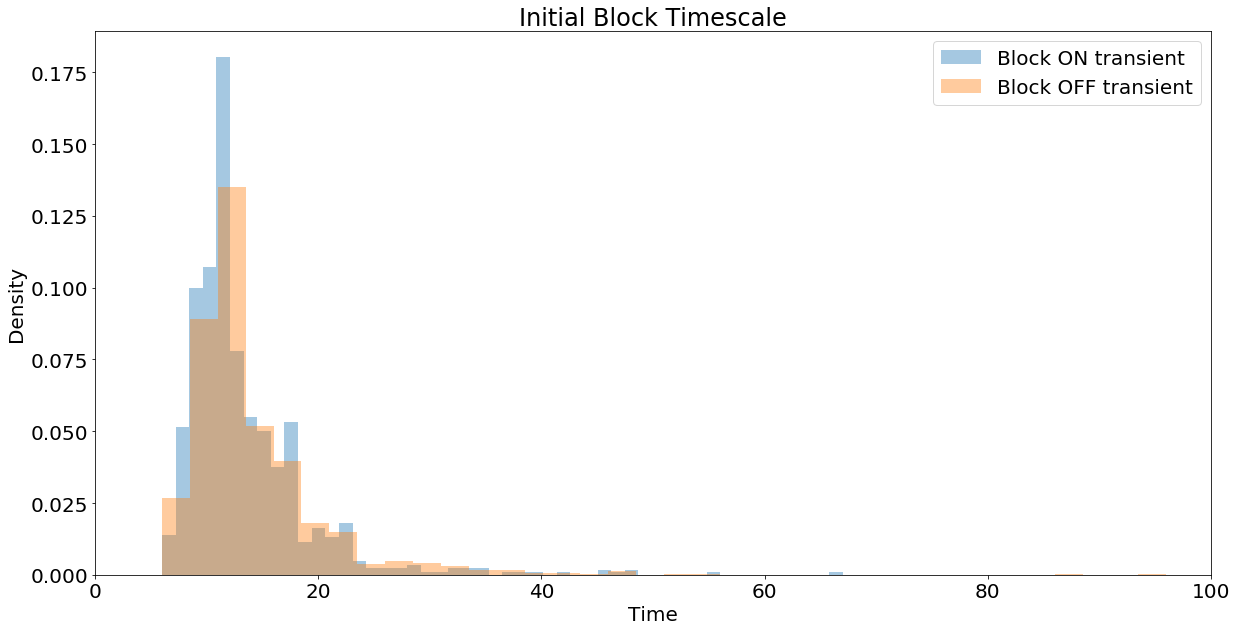

In [77]:
sns.distplot(
    initial_on_trans, kde=False, bins=50, norm_hist=True, label="Block ON transient"
)
sns.distplot(
    initial_off_trans, kde=False, bins=50, norm_hist=True, label="Block OFF transient"
)
plt.xlim([0, 100])
plt.legend()
plt.title("Initial Block Timescale")
plt.ylabel("Density")
plt.xlabel("Time")
plt.show()

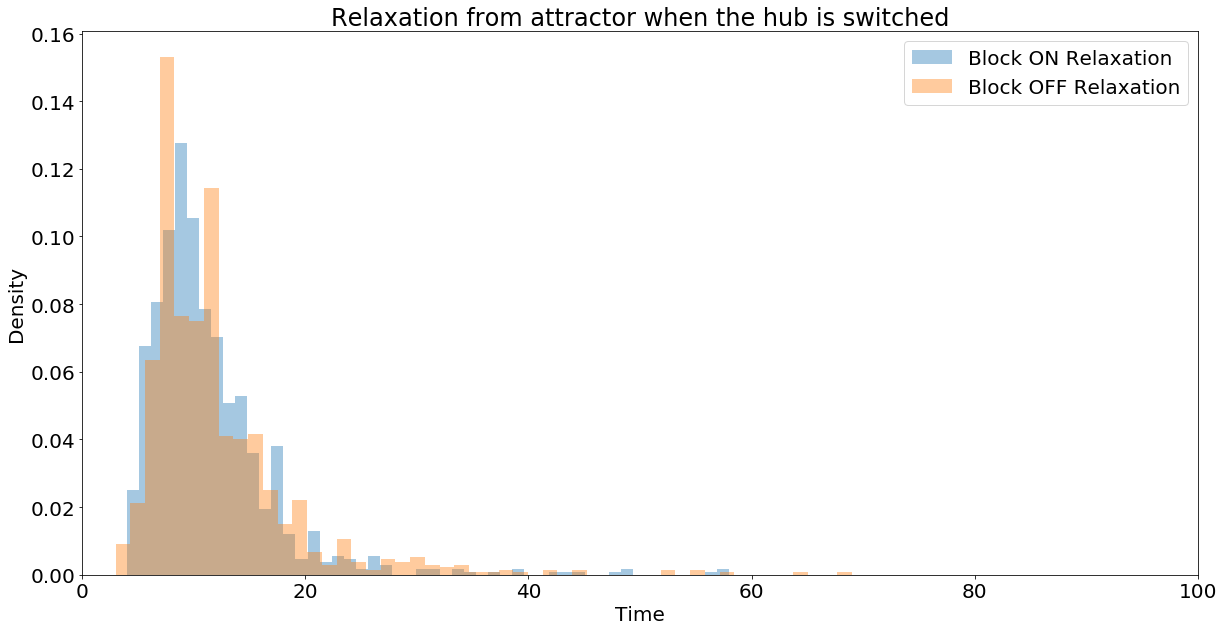

In [78]:
sns.distplot(on_relax, kde=False, bins=50, norm_hist=True, label="Block ON Relaxation")
sns.distplot(
    off_relax, kde=False, bins=50, norm_hist=True, label="Block OFF Relaxation"
)
plt.xlim([0, 100])
plt.legend()
plt.title("Relaxation from attractor when the hub is switched")
plt.ylabel("Density")
plt.xlabel("Time")
plt.show()

Conclusion.. going from off to on attractor has a longer time scale than going from an on attractor to an off attractor.  We should run this with larger numbers, or perhaps the same networks. 

In [79]:
np.mean(initial_on_trans), np.mean(off_relax)

(13.363, 12.051)

In [80]:
np.mean(on_relax), np.mean(initial_off_trans)

(11.505, 14.166)

In [72]:
my_graph = SFGraph(1000, 2.5)

Average for many networks

In [12]:
np.round(np.linspace(1.6, 3.0, 20), decimals=3)

array([1.6  , 1.674, 1.747, 1.821, 1.895, 1.968, 2.042, 2.116, 2.189,
       2.263, 2.337, 2.411, 2.484, 2.558, 2.632, 2.705, 2.779, 2.853,
       2.926, 3.   ])

### More specifically, can we probe the relaxation time going between ON and OFF attractors

In [5]:
#### For many graphs, figure out the relaxation time going to an ON attractor, then to an OFF attractor
n = 1000
gams = np.round(
    np.linspace(1.6, 3.0, 20), decimals=3
)  # np.round(np.linspace(1.7, 3.5, 15), decimals=3)
trials = 500
on_to_off = []
off_to_on = []
for gamma in gams:
    print(gamma)
    relaxation_list_ONOFF = []
    relaxation_list_OFFON = []
    for _ in range(trials):
        my_graph = SFGraph(n, gamma)
        to_on = go_to_attractor(
            graph=my_graph, block_state=Graph.ON, control_node=my_graph.find_hub()
        )
        to_off = go_to_attractor(
            graph=my_graph, block_state=Graph.OFF, control_node=my_graph.find_hub()
        )
        relaxation_list_ONOFF.append(to_off)

        my_graph.random_config()
        to_off = go_to_attractor(
            graph=my_graph, block_state=Graph.OFF, control_node=my_graph.find_hub()
        )
        to_on = go_to_attractor(
            graph=my_graph, block_state=Graph.ON, control_node=my_graph.find_hub()
        )
        relaxation_list_OFFON.append(to_on)
    on_to_off.append(np.mean(relaxation_list_ONOFF))
    off_to_on.append(np.mean(relaxation_list_OFFON))

1.6
1.674
1.747
1.821
1.895
1.968
2.042
2.116
2.189
2.263
2.337
2.411
2.484
2.558
2.632
2.705
2.779
2.853
2.926
3.0


In [6]:
np.save("/Users/Sam/Desktop/relax_on_off_500", np.array(on_to_off))
np.save("/Users/Sam/Desktop/relax_off_on_500", np.array(off_to_on))

In [41]:
gams = np.round(
    np.linspace(1.6, 3.0, 20), decimals=3
)  # np.round(np.linspace(1.7, 3.5, 15), decimals=3)
on_to_off = np.load(
    "/Users/Sam/Documents/Harvard/Research/Results/Oscillating/Time Scale When Blocked/relax_on_off.npy"
)
off_to_on = np.load(
    "/Users/Sam/Documents/Harvard/Research/Results/Oscillating/Time Scale When Blocked/relax_off_on.npy"
)

# on_to_off = np.load("/Users/Sam/Documents/Harvard/Research/Results/Oscillating/Time Scale When Blocked/relax_on_off_500.npy")
# off_to_on = np.load("/Users/Sam/Documents/Harvard/Research/Results/Oscillating/Time Scale When Blocked/relax_off_on_500.npy")

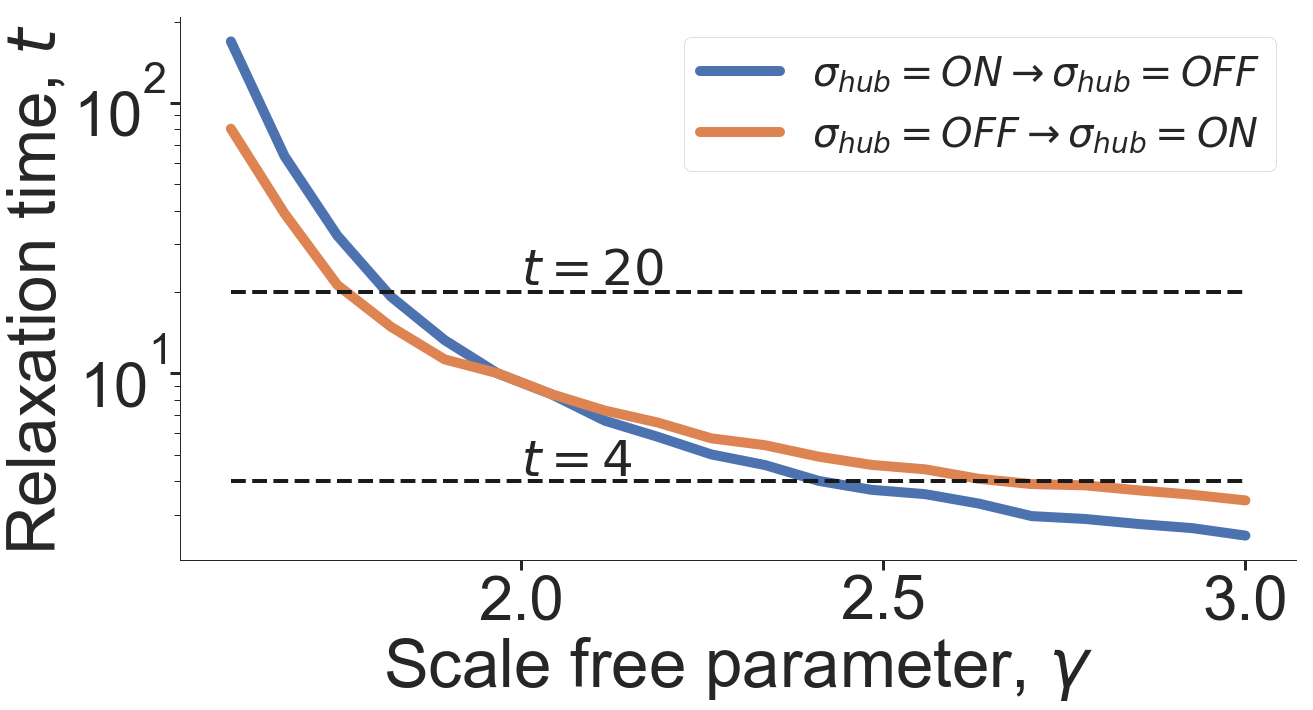

In [40]:
plt.semilogy(
    gams, on_to_off, label=r"$\sigma_{hub} = ON\rightarrow\sigma_{hub} = OFF$", zorder=1
)
plt.semilogy(
    gams, off_to_on, label=r"$\sigma_{hub} = OFF\rightarrow\sigma_{hub} = ON$", zorder=1
)
plt.xlabel(
    r"Scale free parameter, $\gamma$",
)
plt.ylabel("Relaxation time, $t$")

plt.hlines(xmin=1.6, xmax=3.0, y=4, linestyles="--", linewidth=4, zorder=2)
plt.hlines(xmin=1.6, xmax=3.0, y=20, linestyles="--", linewidth=4, zorder=2)
plt.text(2.0, 4.2, "$t=4$", fontsize=50)
plt.text(2.0, 21.5, "$t=20$", fontsize=50)


# For n=500
# plt.hlines(xmin=1.6, xmax=3.0, y=10, linestyles="--", linewidth=4, zorder=2)
# plt.text(1.63,11, "$t=10$", fontsize=50)


plt.legend()
sns.despine()
plt.savefig("/Users/Sam/Desktop/timescale.pdf", bbox_inches="tight")
plt.show()

In [20]:
on_to_off, off_to_on, gams

([5187.862,
  718.204,
  137.326,
  44.682,
  19.622,
  13.512,
  9.882,
  7.732,
  6.832,
  6.022,
  5.184,
  4.632,
  4.162,
  3.962,
  3.628,
  3.422,
  3.272,
  2.964,
  2.864,
  2.734],
 [969.82,
  315.518,
  53.684,
  25.99,
  16.014,
  12.684,
  10.16,
  8.288,
  7.41,
  6.61,
  6.006,
  5.506,
  5.14,
  4.734,
  4.54,
  4.332,
  4.056,
  3.996,
  3.866,
  3.698],
 array([1.6  , 1.674, 1.747, 1.821, 1.895, 1.968, 2.042, 2.116, 2.189,
        2.263, 2.337, 2.411, 2.484, 2.558, 2.632, 2.705, 2.779, 2.853,
        2.926, 3.   ]))

## Now probing single gamma, different values of N 

In [24]:
np.round(np.linspace(100, 2000, 20))

array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800.,
       1900., 2000.])

In [22]:
#### For many graphs, figure out the relaxation time going to an ON attractor, then to an OFF attractor
n_vals = np.round(np.linspace(100, 2000, 20)).astype(
    int
)  # np.round(np.linspace(1.7, 3.5, 15), decimals=3)
trials = 1000
gamma = 1.8
on_to_off = []
off_to_on = []
for n in n_vals:
    relaxation_list_ONOFF = []
    relaxation_list_OFFON = []
    print(n)
    for _ in range(trials):
        my_graph = SFGraph(n, gamma)
        to_on = go_to_attractor(
            graph=my_graph, block_state=Graph.ON, control_node=my_graph.find_hub()
        )
        to_off = go_to_attractor(
            graph=my_graph, block_state=Graph.OFF, control_node=my_graph.find_hub()
        )
        relaxation_list_ONOFF.append(to_off)
        my_graph.random_config()
        to_off = go_to_attractor(
            graph=my_graph, block_state=Graph.OFF, control_node=my_graph.find_hub()
        )
        to_on = go_to_attractor(
            graph=my_graph, block_state=Graph.ON, control_node=my_graph.find_hub()
        )
        relaxation_list_OFFON.append(to_on)
    on_to_off.append(np.mean(relaxation_list_ONOFF))
    off_to_on.append(np.mean(relaxation_list_OFFON))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [23]:
text_gam = str(gamma).replace(".", "_")
np.save(f"/Users/Sam/Desktop/relax_on_off_gam{text_gam}", np.array(on_to_off))
np.save(f"/Users/Sam/Desktop/relax_off_on_gam{text_gam}", np.array(off_to_on))
np.save(f"/Users/Sam/Desktop/relax_gam{text_gam}_nvals", np.array(n_vals))

In [24]:
#### For many graphs, figure out the relaxation time going to an ON attractor, then to an OFF attractor
n_vals = np.round(np.linspace(100, 2000, 20)).astype(
    int
)  # np.round(np.linspace(1.7, 3.5, 15), decimals=3)
trials = 1000
gamma = 1.9
on_to_off = []
off_to_on = []
for n in n_vals:
    relaxation_list_ONOFF = []
    relaxation_list_OFFON = []
    print(n)
    for _ in range(trials):
        my_graph = SFGraph(n, gamma)
        to_on = go_to_attractor(
            graph=my_graph, block_state=Graph.ON, control_node=my_graph.find_hub()
        )
        to_off = go_to_attractor(
            graph=my_graph, block_state=Graph.OFF, control_node=my_graph.find_hub()
        )
        relaxation_list_ONOFF.append(to_off)
        my_graph.random_config()
        to_off = go_to_attractor(
            graph=my_graph, block_state=Graph.OFF, control_node=my_graph.find_hub()
        )
        to_on = go_to_attractor(
            graph=my_graph, block_state=Graph.ON, control_node=my_graph.find_hub()
        )
        relaxation_list_OFFON.append(to_on)
    on_to_off.append(np.mean(relaxation_list_ONOFF))
    off_to_on.append(np.mean(relaxation_list_OFFON))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [25]:
text_gam = str(gamma).replace(".", "_")
np.save(f"/Users/Sam/Desktop/relax_on_off_gam{text_gam}", np.array(on_to_off))
np.save(f"/Users/Sam/Desktop/relax_off_on_gam{text_gam}", np.array(off_to_on))
np.save(f"/Users/Sam/Desktop/relax_gam{text_gam}_nvals", np.array(n_vals))

In [3]:
gamma = 1.9
text_gam = str(gamma).replace(".", "_")
on_to_off = np.load(f"/Users/Sam/Desktop/relax_on_off_gam{text_gam}.npy")
off_to_on = np.load(f"/Users/Sam/Desktop/relax_off_on_gam{text_gam}.npy")
n_vals = np.load(f"/Users/Sam/Desktop/relax_gam{text_gam}_nvals.npy")


# on_to_off = np.load("/Users/Sam/Documents/Harvard/Research/Results/Oscillating/Time Scale When Blocked/relax_on_off.npy")
# off_to_on = np.load("/Users/Sam/Documents/Harvard/Research/Results/Oscillating/Time Scale When Blocked/relax_off_on.npy")

# on_to_off = np.load("/Users/Sam/Documents/Harvard/Research/Results/Oscillating/Time Scale When Blocked/relax_on_off_500.npy")
# off_to_on = np.load("/Users/Sam/Documents/Harvard/Research/Results/Oscillating/Time Scale When Blocked/relax_off_on_500.npy")

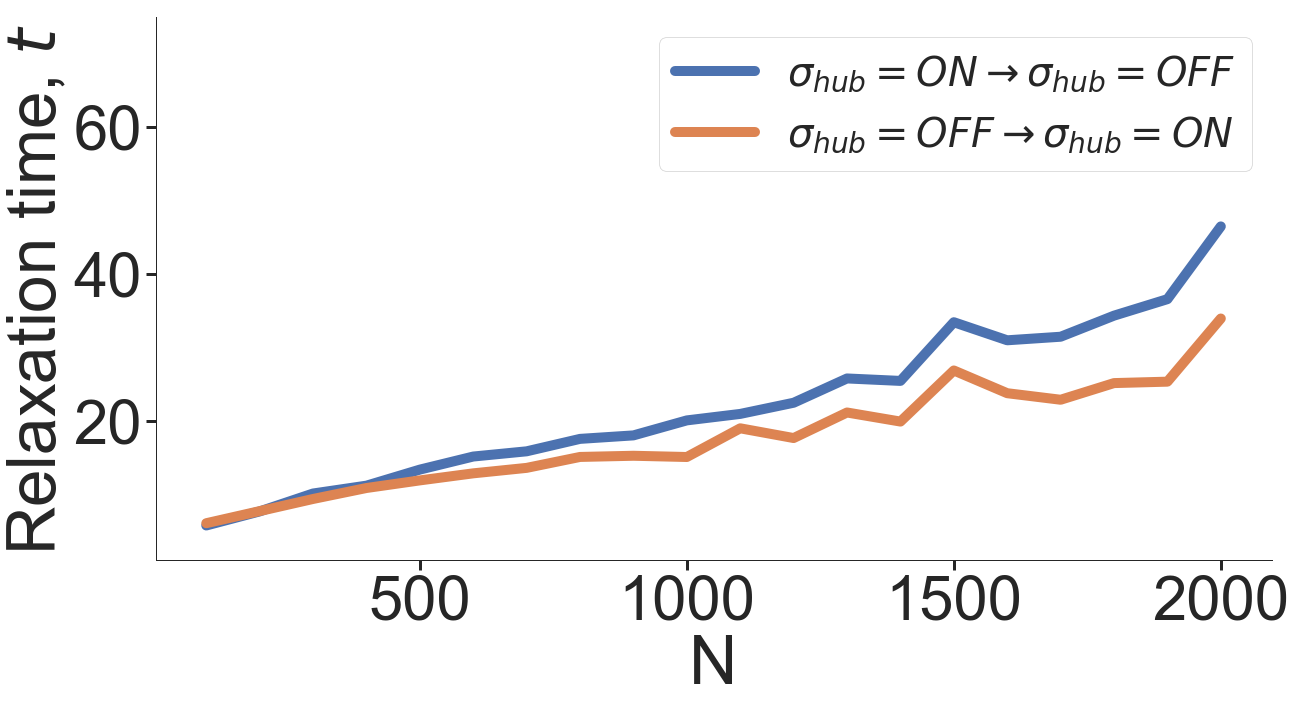

In [34]:
plt.plot(
    n_vals,
    on_to_off,
    label=r"$\sigma_{hub} = ON\rightarrow\sigma_{hub} = OFF$",
    zorder=1,
)
plt.plot(
    n_vals,
    off_to_on,
    label=r"$\sigma_{hub} = OFF\rightarrow\sigma_{hub} = ON$",
    zorder=1,
)
plt.xlabel(
    r"N",
)
plt.ylabel("Relaxation time, $t$")

# plt.hlines(xmin=1.6, xmax=3.0, y=4, linestyles="--", linewidth=4, zorder=2)
# plt.hlines(xmin=1.6, xmax=3.0, y=20, linestyles="--", linewidth=4, zorder=2)
plt.ylim([1, 75])
# plt.text(2.,4.2, "$t=4$", fontsize=50)
# plt.text(2.,21.5, "$t=20$", fontsize=50)


# For n=500
# plt.hlines(xmin=1.6, xmax=3.0, y=10, linestyles="--", linewidth=4, zorder=2)
# plt.text(1.63,11, "$t=10$", fontsize=50)


plt.legend(loc="upper right")
sns.despine()
plt.savefig("/Users/Sam/Desktop/timescale.pdf", bbox_inches="tight")
plt.show()

In [14]:
current_palette = sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

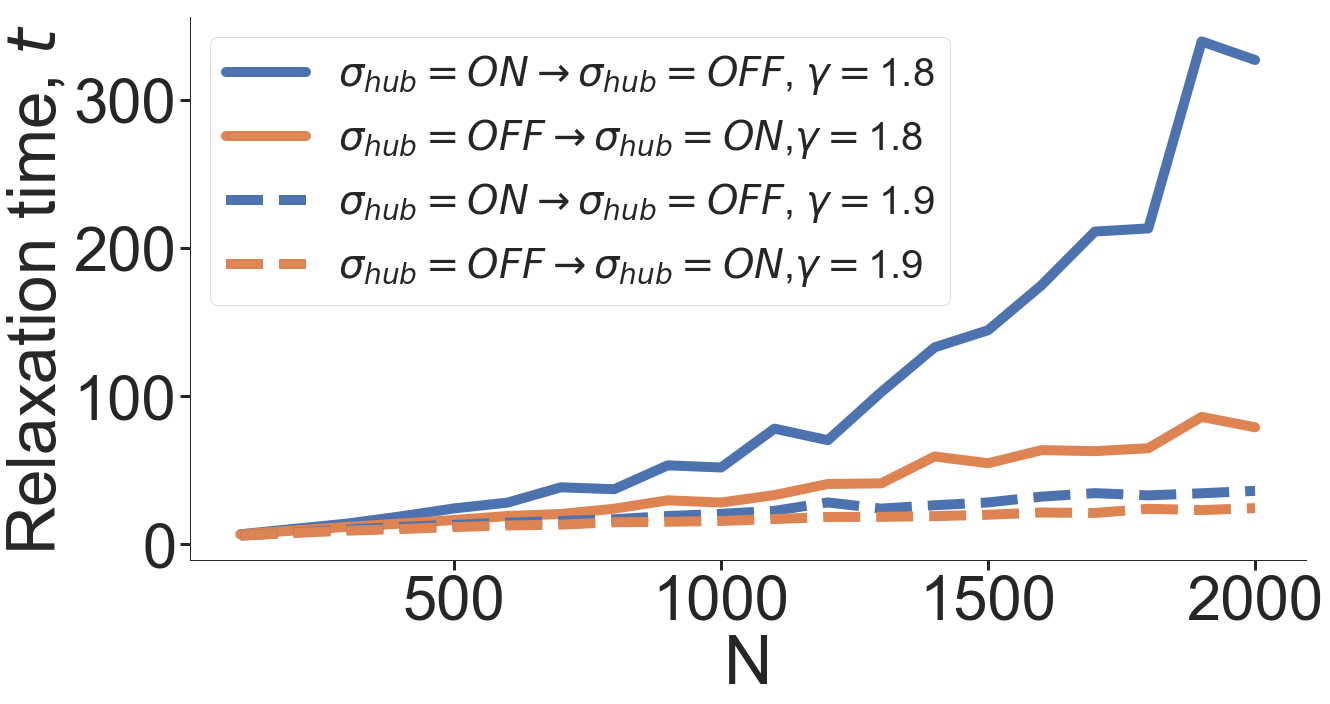

In [31]:
import matplotlib.lines as mlines

gammas = [1.8, 1.9]
linestyles = ["-", "--"]

for num, gamma in enumerate(gammas):
    text_gam = str(gamma).replace(".", "_")
    on_to_off = np.load(f"/Users/Sam/Desktop/relax_on_off_gam{text_gam}.npy")
    off_to_on = np.load(f"/Users/Sam/Desktop/relax_off_on_gam{text_gam}.npy")
    n_vals = np.load(f"/Users/Sam/Desktop/relax_gam{text_gam}_nvals.npy")
    plt.plot(
        n_vals,
        on_to_off,
        linestyle=linestyles[num],
        color=current_palette[0],
        zorder=1,
        label=r"$\sigma_{hub} = ON\rightarrow\sigma_{hub} = OFF$, $\gamma=$"
        + f"{gammas[num]}",
    )
    plt.plot(
        n_vals,
        off_to_on,
        linestyle=linestyles[num],
        color=current_palette[1],
        zorder=1,
        label=r"$\sigma_{hub} = OFF\rightarrow\sigma_{hub} = ON$,$\gamma=$"
        + f"{gammas[num]}",
    )


plt.xlabel(
    r"N",
)
plt.ylabel("Relaxation time, $t$")


plt.legend(loc="upper left")


sns.despine()
plt.savefig("/Users/Sam/Desktop/timescale.pdf", bbox_inches="tight")

## New heading